## K-means clustering-inspired segmentation

In [1]:
import matplotlib.pyplot as plt
from skimage.future import graph
from skimage import data, segmentation, color, filters, io

In [3]:
im = plt.imread('C:/Users/koolk/OneDrive/teaching/cheme599/FB_IMG_1586527675876.jpg')
im_g = color.rgb2gray(im)

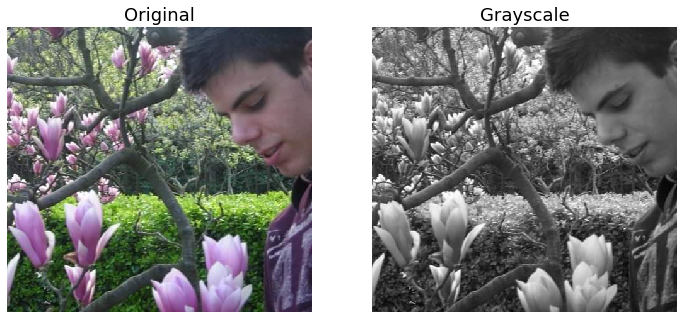

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
titles = ['Original', 'Grayscale']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=18)


axes[0].imshow(im)
axes[1].imshow(im_g, cmap='gray')

In this example, we're going to take advantage of a machine learning algorithm known as [k means clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html). K-means clustering is an unsupervised machine learning method, meaning there is no target output we're trying to force on our model. K-means clustering tries to look for similarities in your data based on whatever features you provide. In case of colored images, our features are the R, G, and B components, as well as the spatial coordinates of the pixels. We are going to try to look for clusters of similarly colored pixels that are preferably close to each other to break our image into regions.

In this first step, we will find the regions via clustering, and then take the "average" shade in each region to reconstruct a "simplified" version of the image. By itself, this method has some pretty results using the coffee cup. Try changing the number of segments in the K-means clustering algorithm to see how it affects the image.

In [23]:
labels = segmentation.slic(im, compactness=30, n_segments=2000)
im_label = color.label2rgb(labels, image=im_g)
im_out = color.label2rgb(labels, im, kind='avg')

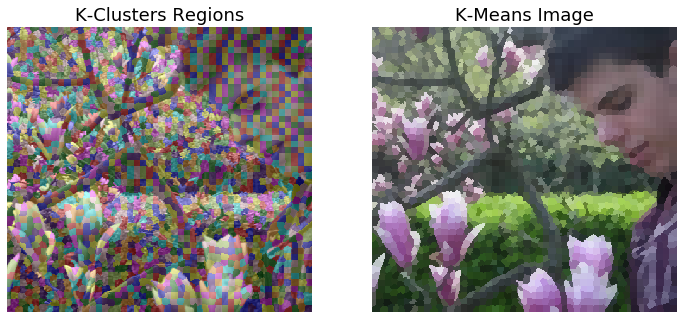

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
titles = ['K-Clusters Regions', 'K-Means Image']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    
axes[0].imshow(im_label, cmap='prism')
axes[1].imshow(im_out)
#axes[1].imshow(edges_rgb)

We are going to further improve the image by using something called a Region Adjacency Graph (RAG). The RAG takes into account both the region clusters defined by the K-means clustering algorithm as well as the edges found in the image via a Sobel filter.

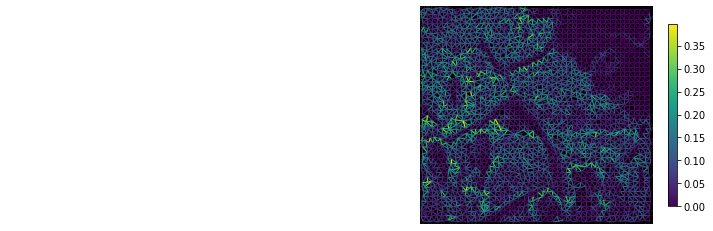

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
#titles = ['K-Clusters Regions', 'Sobel Edges']

for ax, title in zip(axes, titles):
    ax.axis('off')
    #ax.set_title(title, fontsize=18)

edges = filters.sobel(im_g)
edges_rgb = color.gray2rgb(edges)
g = graph.rag_boundary(labels, edges)
lc = graph.show_rag(labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis', edge_width=1.2, ax=axes[1])

fig.colorbar(lc, fraction=0.03)
#axes[0].imshow(im_label, cmap='prism')
#axes[1].imshow(im_out)

In [16]:
def merge_boundary(graph, src, dst):
    """Call back called before merging two nodes.
    
    In this case, there is no computation.
    """
    pass


def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary adjacency graph.
    
    This function computes the "weight" and the "count" attributes
    of the edge between "n" and the node formed after merging "src"
    and "dst".
    
    Parameters
    ----------
    graph : RAG
        The graph under consideration
    src, dst : int
        The vertices in "graph" to be merged
    n : int
        A neighbor of "src" or "dst" or both.
        
    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes
        to be assigned for the merged node.
    """
    
    default = {'weight': 0.0, "count": 0}
    
    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']
    
    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']
    
    count = count_src + count_dst
    
    return {
        'count': count,
        'weight': (count_src*weight_src + count_dst*weight_dst)/count
    }
    
    

In [44]:
label2 = graph.merge_hierarchical(labels, g, thresh=0.009, rag_copy=False, in_place_merge=True,
                                  merge_func=merge_boundary, weight_func=weight_boundary)

im_label2 = color.label2rgb(label2, image=im_g)
im_out2 = color.label2rgb(label2, im, kind='avg')

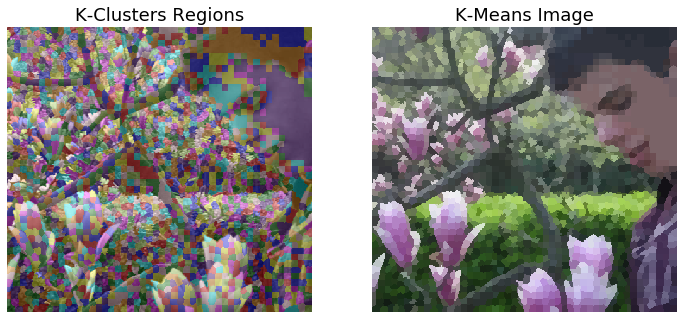

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(12,7))
titles = ['K-Clusters Regions', 'K-Means Image']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    
axes[0].imshow(im_label2, cmap='prism')
axes[1].imshow(im_out2)
#axes[1].imshow(edges_rgb)

In [47]:
plt.imsave('C:/Users/koolk/OneDrive/teaching/cheme599/me_and_flowers.jpg', im_out2)